# Custom Training Job Using Built-in Algorithm (PreBuilt in Container Image)
- Load Data to S3 Bucket
- Read Data from the S3 Bucket
- Preprocess the data i.e. Fill missings, OneHotEncoder, StandardScaler
- Train a XGBoost Model using sagemaker.image_uris.retrieve, sagemaker.estimator.Estimator
- Deploy the model using Estimator_instance.deploy()
- Make Predictions using the instance data point. Note: Serializer and Deserializer are important to look at.
- Delete the Endpoint using sagemaker session or boto sagemaker client


In [1]:
import pandas as pd    
import numpy as np    
import boto3   
import sagemaker  


/opt/conda/lib/python3.12/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
ROLE = sagemaker.get_execution_role()
print(ROLE)

boto_session = boto3.session.Session()
REGION = boto_session.region_name
print(REGION)

sagemaker_session = sagemaker.session.Session(boto_session=boto_session)
BUCKET = sagemaker_session.default_bucket()
print(BUCKET)

s3_boto_client = boto_session.client("s3")
sagemaker_boto_client = boto_session.client("sagemaker")

PREFIX_KEY = "DEMO-sagemaker-clarify"

arn:aws:iam::205930620783:role/service-role/AmazonSageMaker-ExecutionRole-20250401T145997
us-east-1
sagemaker-us-east-1-205930620783


## Upload the local data to s3 bucket

In [3]:
# Upload the data to a s3 bucker
sagemaker_session.upload_data(path="data/adult.data", bucket=BUCKET, key_prefix=f"{PREFIX_KEY}/data")
sagemaker_session.upload_data(path="data/adult.test", bucket=BUCKET, key_prefix=f"{PREFIX_KEY}/data")

's3://sagemaker-us-east-1-205930620783/DEMO-sagemaker-clarify/data/adult.test'

## Read data from the s3 bucker and assign names to the columns

In [4]:
train_uri = "s3://sagemaker-us-east-1-205930620783/DEMO-sagemaker-clarify/data/adult.data"
test_uri = "s3://sagemaker-us-east-1-205930620783/DEMO-sagemaker-clarify/data/adult.test"

In [5]:
adult_columns = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Marital Status",
    "Occupation",
    "Relationship",
    "Ethnic group",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "Target",
]

train = pd.read_csv(train_uri, names=adult_columns, sep=r"\s*,\s*", engine="python")
test = pd.read_csv(test_uri, names=adult_columns, sep=r"\s*,\s*", engine="python")
print(train.shape, test.shape)
print(train['Target'].value_counts())
print(test['Target'].value_counts())
train.head()
#print(test.columns)

(32561, 15) (16282, 15)
Target
<=50K    24720
>50K      7841
Name: count, dtype: int64
Target
<=50K.    12435
>50K.      3846
Name: count, dtype: int64


,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


<Axes: title={'center': 'Counts of Sex'}, xlabel='Sex'>

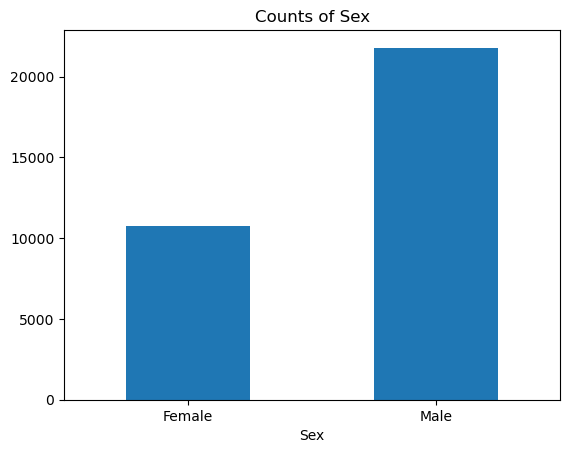

In [6]:
%matplotlib inline
train["Sex"].value_counts().sort_values().plot(kind="bar", title="Counts of Sex", rot=0)

<Axes: title={'center': 'Counts of Sex earning >$50K'}, xlabel='Sex'>

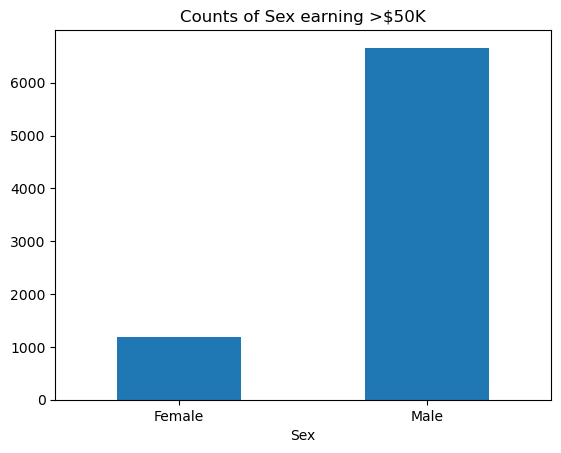

In [7]:
train["Sex"].where(train["Target"] == ">50K").value_counts().sort_values().plot(
    kind="bar", title="Counts of Sex earning >$50K", rot=0
)

### Preprocess data

Transform Columns i.e.
1. Fill Missings with "None" and Encode categorical features
2. Fill missing with -1 and Standardize numerical features


In [10]:
target = 'Target'
from preprocess_data import preprocess_data_general_util
train2, _ = preprocess_data_general_util(train, test, target)
print(train2.shape)
print(train2.columns)
train2.to_csv("data/train_preocessed.csv", index=False)

Numeric Feature:  ['Age', 'fnlwgt', 'Education-Num', 'Capital Gain', 'Capital Loss', 'Hours per week']
Categoy Feature:  ['Workclass', 'Education', 'Marital Status', 'Occupation', 'Relationship', 'Ethnic group', 'Sex', 'Country', 'Target']
['Target_>50K']
(32561, 15) (16282, 15)
(32561, 101)
Index(['Target_>50K', 'Age', 'fnlwgt', 'Education-Num', 'Capital Gain',
       'Capital Loss', 'Hours per week', 'Workclass_Federal-gov',
       'Workclass_Local-gov', 'Workclass_Never-worked',
       ...
       'Country_Portugal', 'Country_Puerto-Rico', 'Country_Scotland',
       'Country_South', 'Country_Taiwan', 'Country_Thailand',
       'Country_Trinadad&Tobago', 'Country_United-States', 'Country_Vietnam',
       'Country_Yugoslavia'],
      dtype='object', length=101)
(32561, 101)
Index(['Target_>50K', 'Age', 'fnlwgt', 'Education-Num', 'Capital Gain',
       'Capital Loss', 'Hours per week', 'Workclass_Federal-gov',
       'Workclass_Local-gov', 'Workclass_Never-worked',
       ...
       'Co

### Upload the processed data to s3

In [4]:
from sagemaker.s3 import S3Uploader
train_uri = S3Uploader.upload("data/train_preocessed.csv", "s3://{}/{}/data".format(BUCKET, PREFIX_KEY))
#test_uri = S3Uploader.upload("test_features.csv", "s3://{}/{}".format(bucket, prefix))
print(train_uri)

s3://sagemaker-us-east-1-205930620783/DEMO-sagemaker-clarify/data/train_preocessed.csv


## Train XGBoost Model
Using the Estimator API that manages everythin under the hood, i.e. no need to manually create an EC2 instance, and setting up everything to run model on that instance.

The Estimator API creates a training job and runs the model using a pre-built container.

By default the first column is the Target and rest of the columns are feature. Convert the target column to int for classification. 

In [5]:
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator
from sagemaker.image_uris import retrieve


train_input = TrainingInput(train_uri, content_type="csv")
print(train_input)

# This references the AWS managed XGBoost container
xgboost_image_uri = retrieve("xgboost", REGION, version="1.5-1")

# Instantiate the training job/ Estimator
xgb =  sagemaker.estimator.Estimator(
    xgboost_image_uri,  
    ROLE,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    disable_profiler=True,
    sagemaker_session=sagemaker_session,
    output_path= f"s3://{BUCKET}/{PREFIX_KEY}/training_jobs"
)
# Setting the hyperparams, you can give it above also.
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    objective="binary:logistic",
    num_round=800,
)
# Fit the model on train data
xgb.fit({"train": train_input}, logs=False)

[06/01/25 05:29:57] INFO     Ignoring unnecessary instance type: None.                            ]8;id=663475;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=10157;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=974210;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=350947;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=613583;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=861071;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-06-01-05-29-57-708                                             


2025-06-01 05:29:59 Starting - Starting the training job..
2025-06-01 05:30:14 Starting - Preparing the instances for training...
2025-06-01 05:30:34 Downloading - Downloading input data....
2025-06-01 05:30:59 Downloading - Downloading the training image........
2025-06-01 05:31:45 Training - Training image download completed. Training in progress..................
2025-06-01 05:33:16 Uploading - Uploading generated training model.
2025-06-01 05:33:29 Completed - Training job completed


## Deploy the model on an endpoint for prediction
The following will create a model in "Models" section in "Sagemaker AI/Endponit/Inference/Models" and deploy it on a endpoint.

In [8]:
xgb_predictor = xgb.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=sagemaker.serializers.CSVSerializer()
)

[06/01/25 05:35:35] INFO     Creating model with name: sagemaker-xgboost-2025-06-01-05-35-35-872    ]8;id=994516;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=461373;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4094\4094]8;;\

[06/01/25 05:35:36] INFO     Creating endpoint-config with name                                     ]8;id=990566;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=901595;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#5937\5937]8;;\
                             sagemaker-xgboost-2025-06-01-05-35-35-872                                             

[06/01/25 05:35:37] INFO     Creating endpoint with name sagemaker-xgboost-2025-06-01-05-35-35-872  ]8;id=414918;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=94856;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4759\4759]8;;\

-------!

## Predict & Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making a http POST request. But first, we’ll need to set up serializers and deserializers for passing our test_data NumPy arrays to the model behind the endpoint.

Now, we’ll use a simple function to: 
1. Loop over our test dataset
2. Split it into mini-batches of rows
3. Convert those mini-batchs to CSV string payloads
4. Retrieve mini-batch predictions by invoking the XGBoost endpoint
5. Collect predictions and convert from the CSV output our model provides into a NumPy array


In [30]:
train_data = pd.read_csv("s3://sagemaker-us-east-1-205930620783/DEMO-sagemaker-clarify/data/train_preocessed.csv")
print("Target: ", train_data.columns[0])
#print(train_data.dtypes)
print(train_data[train_data.columns[0]].value_counts())
print(train_data.iloc[0,1:5].values)
print("Actual Label: ", train_data.iloc[0:5, 0])

predictions = xgb_predictor.predict(train_data.iloc[0:5,1:].values)
print("Prediction Raw: ", predictions)
print("Prediction: ", predictions.decode("utf-8"))

Target:  Target_>50K
Target_>50K
0.0    24720
1.0     7841
Name: count, dtype: int64
[ 0.03067056 -1.06361075  1.13473876  0.1484529 ]
Actual Label:  0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Target_>50K, dtype: float64
Prediction Raw:  b'0.001566360704600811\n0.1893826574087143\n0.01998027227818966\n0.09804678708314896\n0.41704896092414856\n'
Prediction:  0.001566360704600811
0.1893826574087143
0.01998027227818966
0.09804678708314896
0.41704896092414856



In [53]:
import pandas as pd
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = []
    for array in split_array:
        predictions = predictions + [','.join(xgb_predictor.predict(array).decode("utf-8").split('\n'))[:-1]] 
        #print(predictions)
    predictions = ','.join(predictions)
    return np.fromstring(predictions, sep=",")


predictions = predict(train_data.to_numpy()[:, 1:])


In [54]:
#print(predictions)
print(predictions.shape)
print(train_data.shape)

(32561,)
(32561, 101)


In [56]:
pd.crosstab(
    index=train_data.iloc[:, 0],
    columns=np.where(predictions > .5, 1.,0.),
    rownames=["actual"],
    colnames=["predictions"],
)

predictions,0.0,1.0
actual,,
0.0,23594,1126
1.0,2173,5668


## Delete the endpoint
To stop incurring charges

In [59]:
#xgb.delete_endpoint() Doesn't work anymore for sagemaker>=2
# use sagemaker session or boto3 sagemaker client
sagemaker_boto_client.delete_endpoint(EndpointName='sagemaker-xgboost-2025-06-01-05-35-35-872')

{'ResponseMetadata': {'RequestId': 'b1e21488-b165-457e-b475-778db6be3548',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b1e21488-b165-457e-b475-778db6be3548',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Sun, 01 Jun 2025 08:16:19 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

## Create a model from the estimator
You need to create the model using the estimator instance. After you created the model, it will appear on the "Sagemaker AI/Inference/Models"

You can also create the model later using the training job name and other details when you describe it.

In [22]:
#training_job_name = "sagemaker-xgboost-2025-05-31-17-59-49-695"
from datetime import datetime
model_name = "Model_Adult-Dataset-{}".format(datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))

model = xgb.create_model(name=model_name)
print(model)
container_def = model.prepare_container_def()
print(container_def)
sagemaker_session.create_model(model_name, ROLE, container_def)

{'Image': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.5-1', 'Environment': {}, 'ModelDataUrl': 's3://sagemaker-us-east-1-205930620783/DEMO-sagemaker-clarify/training_jobs/sagemaker-xgboost-2025-05-31-17-59-49-695/output/model.tar.gz'}


[05/31/25 18:20:34] INFO     Creating model with name: Model_Adult-Dataset-31-05-2025-18-20-34      ]8;id=195308;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=557549;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4094\4094]8;;\

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:8                                                                                    │
│                                                                                                  │
│   5 print(model)                                                                                 │
│   6 container_def = model.prepare_container_def()                                                │
│   7 print(container_def)                                                                         │
│ ❱ 8 sagemaker_session.create_model(model_name, ROLE, container_def)                              │
│   9                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/session.py:4109 in create_model                │
│                                                                                                  │
│   4106 │   │   │   │   else:                                                                     │
│   4107 │   │   │   │   │   raise                                                                 │
│   4108 │   │                                                                                     │
│ ❱ 4109 │   │   self._intercept_create_request(create_model_request, submit, self.create_model._  │
│   4110 │   │   return name                                                                       │
│   4111 │                                                                                         │
│   4112 │   def create_model_from_job(                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/session.py:6726 in _intercept_create_request   │
│                                                                                                  │
│   6723 │   │   │   create (functor): a functor calls the sagemaker client create method          │
│   6724 │   │   │   func_name (str): the name of the function needed intercepting                 │
│   6725 │   │   """                                                                               │
│ ❱ 6726 │   │   return create(request)                                                            │
│   6727 │                                                                                         │
│   6728 │   def _create_inference_recommendations_job_request(                                    │
│   6729 │   │   self,                                                                             │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/session.py:4097 in submit                      │
│                                                                                                  │
│   4094 │   │   │   logger.info("Creating model with name: %s", name)                             │
│   4095 │   │   │   logger.debug("CreateModel request: %s", json.dumps(request, indent=4))        │
│   4096 │   │   │   try:                                                                          │
│ ❱ 4097 │   │   │   │   self.sagemaker_client.create_model(**request)                             │
│   4098 │   │   │   except ClientError as e:                                                      │
│   4099 │   │   │   │   error_code = e.response["Error"]["Code"]                                  │
│   4100 │   │   │   │   message = e.response["Error"]["Message"]                                  │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/botocore/client.py: